In [3]:
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
df = pd.read_csv("Tweets.csv")
df.head()

,Tweet,polarity,subjectivity,Sentiment
0,RT @ChristopherJM: Zelensky also confirms CIA ...,0.000000,0.000000,Negative
1,RT @oryxspioenkop: Russia acquired these vehic...,-0.100000,0.300000,Positive
2,RT @RepMTG: I’m calling for an audit of every ...,-0.035714,0.607143,Positive
3,"RT @KyivIndependent: ""Russian goal seems to be...",0.034091,0.113636,Negative
4,RT @william98161886: I see Rishi just given an...,-0.325521,0.166667,Positive


In [5]:
df.shape

(10167, 4)

In [6]:
df.describe

<bound method NDFrame.describe of                                                    Tweet  polarity  \
0      RT @ChristopherJM: Zelensky also confirms CIA ...  0.000000   
1      RT @oryxspioenkop: Russia acquired these vehic... -0.100000   
2      RT @RepMTG: I’m calling for an audit of every ... -0.035714   
3      RT @KyivIndependent: "Russian goal seems to be...  0.034091   
4      RT @william98161886: I see Rishi just given an... -0.325521   
...                                                  ...       ...   
10162                                                NaN       NaN   
10163                                                NaN       NaN   
10164                                                NaN       NaN   
10165                                                NaN       NaN   
10166                                                NaN       NaN   

       subjectivity Sentiment  
0          0.000000  Negative  
1          0.300000  Positive  
2          0.607143  Positive

In [7]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [8]:
def preprocess(textdata):
    processedText = []
    wordLemm = WordNetLemmatizer()
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    for tweet in textdata:
        tweet = tweet.lower()
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
        processedText.append(tweetwords)
    return processedText

In [9]:
df1 = df.dropna()
df1.describe

<bound method NDFrame.describe of                                                   Tweet  polarity  \
0     RT @ChristopherJM: Zelensky also confirms CIA ...  0.000000   
1     RT @oryxspioenkop: Russia acquired these vehic... -0.100000   
2     RT @RepMTG: I’m calling for an audit of every ... -0.035714   
3     RT @KyivIndependent: "Russian goal seems to be...  0.034091   
4     RT @william98161886: I see Rishi just given an... -0.325521   
...                                                 ...       ...   
9994  RT @RepMTG: I’m calling for an audit of all US...  0.000000   
9995  @kryptedcomedy Actually I’m a Pole born in Lvo... -0.100000   
9996  RT @RT_com: Ukraine admits firing missile near... -0.033333   
9997  RT @ggreenwald: US funding for war in Ukraine ...  0.136364   
9998  RT @valllldo: мелявтан, россиянь агрессиязо эз...  0.000000   

      subjectivity Sentiment  
0         0.000000  Negative  
1         0.300000  Positive  
2         0.607143  Positive  
3         0.1

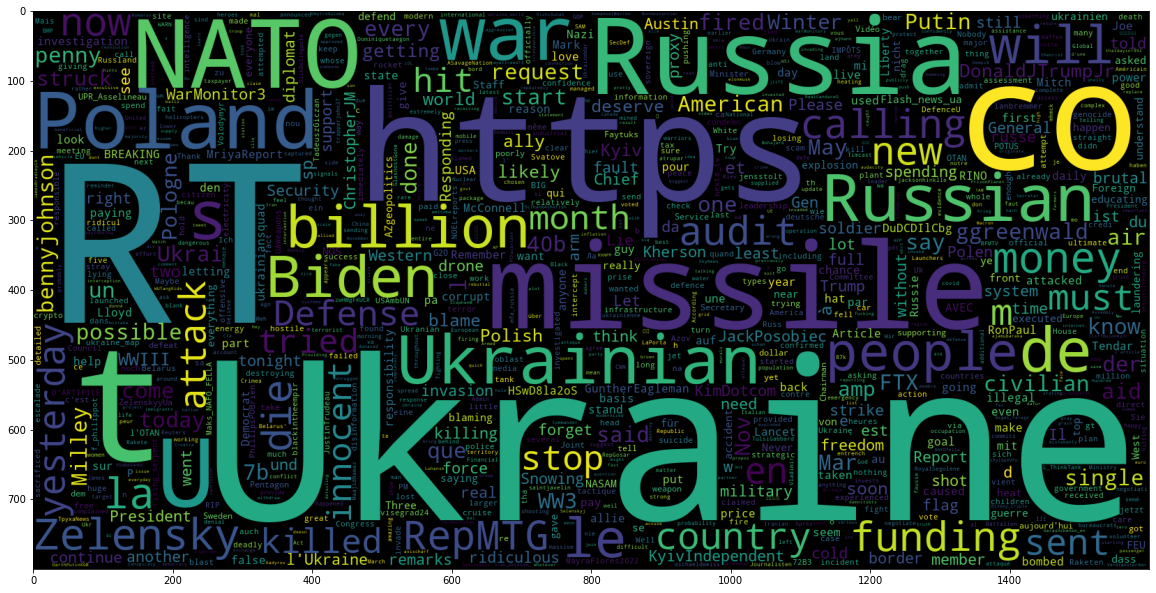

In [10]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(df1['Tweet']))
plt.imshow(wc)

/var/folders/r0/x6474m9x6lz6ws5r_d9w8k0m0000gn/T/ipykernel_6745/2542589613.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Sentiment'].replace(4,1)


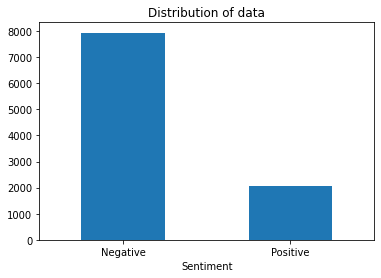

In [11]:
df = df[['Sentiment','Tweet']]
# Replacing the values to ease understanding.
df['Sentiment'] = df['Sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = df.groupby('Sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(df['Tweet']), list(df['Sentiment'])

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df['Tweet'].values.astype('U'), df['Sentiment'].values.astype('U'), 
                                                    test_size = 0.05, random_state = 0)

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [45]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [47]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

    Negative       0.91      1.00      0.96       393
    Positive       1.00      0.77      0.87       102
         nan       0.00      0.00      0.00        14

    accuracy                           0.93       509
   macro avg       0.64      0.59      0.61       509
weighted avg       0.91      0.93      0.91       509



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

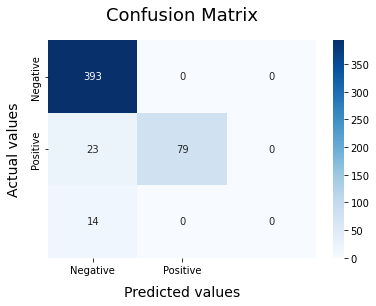

In [48]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

    Negative       0.99      1.00      0.99       393
    Positive       1.00      0.95      0.97       102
         nan       1.00      1.00      1.00        14

    accuracy                           0.99       509
   macro avg       1.00      0.98      0.99       509
weighted avg       0.99      0.99      0.99       509



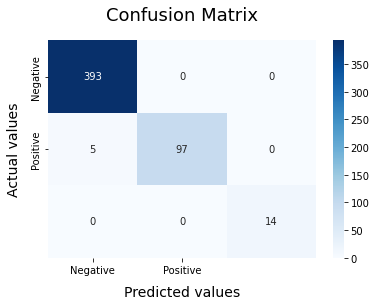

In [49]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

    Negative       0.97      1.00      0.98       393
    Positive       0.99      0.89      0.94       102
         nan       1.00      1.00      1.00        14

    accuracy                           0.98       509
   macro avg       0.99      0.96      0.97       509
weighted avg       0.98      0.98      0.98       509



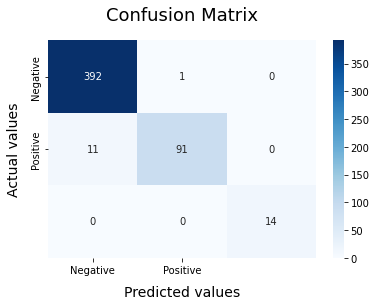

In [50]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)